In [1]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import joblib 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.metrics as mt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import (
    export_graphviz,
    DecisionTreeClassifier,
    DecisionTreeRegressor
    )
    ## check


from sklearn.ensemble import(
    RandomForestClassifier, ## check
    VotingClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor
    )
from sklearn.metrics import(
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay, 
    recall_score,
    precision_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score
    )     ##check
from sklearn.model_selection import (
    train_test_split,
    KFold ,
    StratifiedShuffleSplit,  ## check
    cross_val_score,     ##check
    RandomizedSearchCV
    )


C:\Users\siim2\AppData\Local\Temp\ipykernel_10132\865249908.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
keywords = ["auto","construct","capital_market","chemicals","equipment",
            "transport","semi","bank","steel",
            "telecom","staples","discretionary"]

In [3]:
dfs = {}  # 빈 딕셔너리 생성
column_names_per_keyword = {}

# 각 키워드에 해당하는 데이터프레임을 dfs 딕셔너리에 추가
for keyword in keywords:
    dfs[keyword] = pd.read_excel(r"total_raw02.xlsx", sheet_name=keyword, header=0, index_col=0)
    column_names_per_keyword[keyword] = dfs[keyword].columns.tolist()

    print(f"Compile {keyword}")

# 각 데이터프레임의 인덱스를 날짜 형식으로 변환한 후 문자열로 변경
for keyword, df in dfs.items():
    df.index = pd.to_datetime(df.index)
    df.index = df.index.strftime('%Y-%m-%d')

# 첫 2개 행을 출력
for keyword, df in dfs.items():
    print(f"Top 2 rows of {keyword}:")
    print(df.head(2))
    print(column_names_per_keyword[keyword])

# 첫 번째 데이터프레임의 인덱스를 df_index에 복사하여 초기화
df_index_auto = list(dfs.values())[0]
df_index_construct = list(dfs.values())[1]
df_index_capital_market = list(dfs.values())[2]
df_index_chemicals = list(dfs.values())[3]
df_index_equipment = list(dfs.values())[4]
df_index_transport = list(dfs.values())[5]
df_index_semi = list(dfs.values())[6]
df_index_bank = list(dfs.values())[7]
df_index_steel = list(dfs.values())[8]
df_index_telecom = list(dfs.values())[9]
df_index_staples = list(dfs.values())[10]
df_index_discretionary = list(dfs.values())[11]




Compile auto
Compile construct
Compile capital_market
Compile chemicals
Compile equipment
Compile transport
Compile semi
Compile bank
Compile steel
Compile telecom
Compile staples
Compile discretionary
Top 2 rows of auto:
            auto    WTI  DGS2  DGS10  TIPS    VIX    PPI    per    pbr  \
date                                                                     
2010-04-01  sell  84.53  1.05   3.89  1.61  17.47  172.2  24.13  24.13   
2010-04-05  sell  86.36  1.18   4.01  1.70  17.02  172.2  24.22  24.22   

               원달러  ...   구리선물_60  중국고정자산투자(yoy%)_60  중국 PMI_60   금 선물_60  \
date                ...                                                     
2010-04-01  1131.3  ...  0.000842          -0.003191  -0.001859 -0.000108   
2010-04-05  1126.0  ...  0.001063          -0.003258  -0.001785 -0.000062   

            달러 인덱스_60  중국 소매판매_60  중국 산업 생산_60  MSCI_EMER_60  US_auto_60  \
date                                                                       
2010-04-01   0.00087

In [4]:
# 첫 2개 행을 출력
for keyword, df in dfs.items():
    print(f"Top 2 rows of {keyword}:")
    print(df.head(2))
    print(f"Column names for {keyword}: {column_names_per_keyword[keyword]}")


Top 2 rows of auto:
            auto    WTI  DGS2  DGS10  TIPS    VIX    PPI    per    pbr  \
date                                                                     
2010-04-01  sell  84.53  1.05   3.89  1.61  17.47  172.2  24.13  24.13   
2010-04-05  sell  86.36  1.18   4.01  1.70  17.02  172.2  24.22  24.22   

               원달러  ...   구리선물_60  중국고정자산투자(yoy%)_60  중국 PMI_60   금 선물_60  \
date                ...                                                     
2010-04-01  1131.3  ...  0.000842          -0.003191  -0.001859 -0.000108   
2010-04-05  1126.0  ...  0.001063          -0.003258  -0.001785 -0.000062   

            달러 인덱스_60  중국 소매판매_60  중국 산업 생산_60  MSCI_EMER_60  US_auto_60  \
date                                                                       
2010-04-01   0.000870    0.006153    -0.007687      0.000181   -0.001737   
2010-04-05   0.000855    0.006087    -0.007304      0.000369   -0.001560   

            export_auto_60  
date                        
2010-04-01 

In [5]:
df_index_telecom.head(2)

,telecom,WTI,DGS2,DGS10,TIPS,VIX,PPI,per,pbr,원달러,...,구리선물_60,중국고정자산투자(yoy%)_60,중국 PMI_60,금 선물_60,달러 인덱스_60,중국 소매판매_60,중국 산업 생산_60,MSCI_EMER_60,통신배당_60,IT산업별/월별 수출 현황 중 통신기기 소계_60
date,,,,,,,,,,,,,,,,,,,,,
2010-04-01,sell,84.53,1.05,3.89,1.61,17.47,172.2,24.13,24.13,1131.3,...,0.000842,-0.003191,-0.001859,-0.000108,0.000870,0.006153,-0.007687,0.000181,0.002829,-0.001122
2010-04-05,sell,86.36,1.18,4.01,1.70,17.02,172.2,24.22,24.22,1126.0,...,0.001063,-0.003258,-0.001785,-0.000062,0.000855,0.006087,-0.007304,0.000369,0.002899,-0.000808


In [6]:
for keyword, df in dfs.items():
    df.head(2).info()


<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 2010-04-01 to 2010-04-05
Data columns (total 88 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   auto                   2 non-null      object 
 1   WTI                    2 non-null      float64
 2   DGS2                   2 non-null      float64
 3   DGS10                  2 non-null      float64
 4   TIPS                   2 non-null      float64
 5   VIX                    2 non-null      float64
 6   PPI                    2 non-null      float64
 7   per                    2 non-null      float64
 8   pbr                    2 non-null      float64
 9   원달러                    2 non-null      float64
 10  원엔                     2 non-null      float64
 11  3년물                    2 non-null      float64
 12  10년물                   2 non-null      float64
 13  treasury_10_3_diff     2 non-null      float64
 14  T10Y2Y                 2 non-null      float64
 1

In [7]:
data_splits = {}
for keyword, df_index in dfs.items():
    df_dropna = df_index.dropna()  # 결측치가 있는 행 제거
    
    if df_dropna.empty:
        print(f"Error: Dataframe for {keyword} is empty.")
    else:
        # 종속 변수(y) 및 독립 변수(X) 설정
        y_keyword = df_dropna[keyword]  # 현재 키워드에 해당하는 종속 변수
        X_keyword = df_dropna.drop(columns=[keyword])  # 현재 키워드를 제외한 나머지 열은 독립 변수로 사용

        # 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(X_keyword, y_keyword, test_size=0.2, random_state=0)
        
        # 데이터 정규화
        normalizer = StandardScaler()
        X_train_normalized = normalizer.fit_transform(X_train)
        X_test_normalized = normalizer.transform(X_test)

        # 데이터 저장
        data_splits[keyword] = {
            'X_train': X_train_normalized,
            'X_test': X_test_normalized,
            'y_train': y_train,
            'y_test': y_test
        }

        print(f'Train set dimension for {keyword} is {X_train_normalized.shape}')
        print(f'Test set dimension for {keyword} is {X_test_normalized.shape}')
        # 훈련 데이터와 테스트 데이터의 클래스 비율 확인
        train_class_counts = {label: sum(y_train == label) for label in set(y_keyword)}
        test_class_counts = {label: sum(y_test == label) for label in set(y_keyword)}

        print(f"훈련 데이터 클래스 비율 for {keyword}:", train_class_counts)
        print(f"테스트 데이터 클래스 비율 for {keyword}:", test_class_counts)

Train set dimension for auto is (2633, 87)
Test set dimension for auto is (659, 87)
훈련 데이터 클래스 비율 for auto: {'sell': 1359, 'buy': 500, 'S_buy': 774}
테스트 데이터 클래스 비율 for auto: {'sell': 336, 'buy': 139, 'S_buy': 184}
Train set dimension for construct is (2633, 87)
Test set dimension for construct is (659, 87)
훈련 데이터 클래스 비율 for construct: {'sell': 1304, 'buy': 389, 'S_buy': 940}
테스트 데이터 클래스 비율 for construct: {'sell': 356, 'buy': 95, 'S_buy': 208}
Train set dimension for capital_market is (2633, 87)
Test set dimension for capital_market is (659, 87)
훈련 데이터 클래스 비율 for capital_market: {'buy': 447, 'sell': 1296, 'S_buy': 890}
테스트 데이터 클래스 비율 for capital_market: {'buy': 106, 'sell': 342, 'S_buy': 211}
Train set dimension for chemicals is (2633, 87)
Test set dimension for chemicals is (659, 87)
훈련 데이터 클래스 비율 for chemicals: {'sell': 1392, 'buy': 463, 'S_buy': 778}
테스트 데이터 클래스 비율 for chemicals: {'sell': 340, 'buy': 142, 'S_buy': 177}
Train set dimension for equipment is (2633, 87)
Test set dimensio

### 여러가지 실험을 했다
1. logistic_regression
2. random_forest
3. gradient_boosting
4. svm
5. neural_network

In [8]:
accuracies = {}

# 각 키워드에 대한 분류기 및 Voting Classifier 생성
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    X_test = data_split['X_test']
    y_train = data_split['y_train']
    y_test = data_split['y_test']
    
    random_forest = RandomForestClassifier()
    gradient_boosting = GradientBoostingClassifier()
    svm = SVC()
    knn = KNeighborsClassifier()
    decision_tree = DecisionTreeClassifier()

    # Voting Classifier 생성
    voting_classifier = VotingClassifier(
        estimators=[
            ('rf', random_forest), 
            ('gb', gradient_boosting), 
            ('svm', svm), 
            ('knn', knn),
            ('dt', decision_tree)
        ],
        voting='hard'
    )

    models = {
        'Random Forest': random_forest,
        'Gradient Boosting': gradient_boosting,
        'Support Vector Machine': svm,
        'K-Nearest Neighbors': knn,
        'Decision Tree': decision_tree,
        'Voting Classifier': voting_classifier
    }

    # 각 분류기에 대해 학습하고 평가
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[f'{keyword}_{name}'] = accuracy
        print(f"{keyword} 키워드로 학습한 {name}의 정확도: {accuracy}")

    # 가장 높은 정확도를 가진 모델 찾기
    best_model_name = max(accuracies, key=accuracies.get)
    best_accuracy = accuracies[best_model_name]

    print(f"최고의 성능을 보인 모델은 {best_model_name}로, 정확도는 {best_accuracy:.3f}입니다.")

auto 키워드로 학습한 Random Forest의 정확도: 0.8209408194233687
auto 키워드로 학습한 Gradient Boosting의 정확도: 0.7496206373292867
auto 키워드로 학습한 Support Vector Machine의 정확도: 0.7481031866464339
auto 키워드로 학습한 K-Nearest Neighbors의 정확도: 0.7708649468892261
auto 키워드로 학습한 Decision Tree의 정확도: 0.7769347496206374
auto 키워드로 학습한 Voting Classifier의 정확도: 0.7905918057663126
최고의 성능을 보인 모델은 auto_Random Forest로, 정확도는 0.821입니다.
construct 키워드로 학습한 Random Forest의 정확도: 0.8406676783004552
construct 키워드로 학습한 Gradient Boosting의 정확도: 0.8148710166919575
construct 키워드로 학습한 Support Vector Machine의 정확도: 0.8118361153262519
construct 키워드로 학습한 K-Nearest Neighbors의 정확도: 0.8163884673748103
construct 키워드로 학습한 Decision Tree의 정확도: 0.8012139605462822
construct 키워드로 학습한 Voting Classifier의 정확도: 0.842185128983308
최고의 성능을 보인 모델은 construct_Voting Classifier로, 정확도는 0.842입니다.
capital_market 키워드로 학습한 Random Forest의 정확도: 0.8042488619119879
capital_market 키워드로 학습한 Gradient Boosting의 정확도: 0.7708649468892261
capital_market 키워드로 학습한 Support Vector Machine의 

In [9]:
best_models = {}  # 각 키워드에 대한 최고의 모델을 저장할 딕셔너리


# 각 키워드에 대한 최고의 모델을 출력
for keyword, best_model in best_models.items():
    print(f"{keyword} 키워드에 대한 최적의 모델은 {best_model} 입니다.")


### 최고의 성능 대부분은 Random Forest 모델로, 정확도는 0.8 대략 정확도 80%


### 그러면은 단순 모델링을 해보자

In [10]:
# Train set 및 Test set에 대한 성능을 저장할 딕셔너리 생성
performance_results = {}

# Random Forest 모델 생성
rfc = RandomForestClassifier()

# 각 키워드에 대해 모델을 학습하고 Train set 및 Test set에 대한 성능을 측정
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']
    X_test = data_split['X_test']
    y_test = data_split['y_test']
    
    # 모델 학습
    rfc.fit(X_train, y_train)

    # Train set에 대한 성능 측정
    y_pred_train = rfc.predict(X_train)
    acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)

    # Test set에 대한 성능 측정
    y_pred_test = rfc.predict(X_test)
    acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)

    # 결과 저장
    performance_results[keyword] = {
        'Train 성능': acc_train,
        'Test 성능': acc_test
    }

# 각 키워드에 대한 Train set 및 Test set의 성능 출력
for keyword, performance in performance_results.items():
    print(f"{keyword} 키워드에 대한 성능: ",performance['Test 성능'])
    print()

auto 키워드에 대한 성능:  0.8148710166919575

construct 키워드에 대한 성능:  0.834597875569044

capital_market 키워드에 대한 성능:  0.8103186646433991

chemicals 키워드에 대한 성능:  0.8239757207890743

equipment 키워드에 대한 성능:  0.8285280728376327

transport 키워드에 대한 성능:  0.8467374810318664

semi 키워드에 대한 성능:  0.8163884673748103

bank 키워드에 대한 성능:  0.8103186646433991

steel 키워드에 대한 성능:  0.8209408194233687

telecom 키워드에 대한 성능:  0.8103186646433991

staples 키워드에 대한 성능:  0.858877086494689

discretionary 키워드에 대한 성능:  0.8179059180576631



### test set에 대해서 성능이 한 80~87%정도 나온다 약간 상승!

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


auto 키워드에 대한 최적의 트리 수는 13, 최적의 깊이는 20 입니다.
construct 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 14 입니다.
capital_market 키워드에 대한 최적의 트리 수는 19, 최적의 깊이는 18 입니다.
chemicals 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 20 입니다.
equipment 키워드에 대한 최적의 트리 수는 19, 최적의 깊이는 16 입니다.
transport 키워드에 대한 최적의 트리 수는 17, 최적의 깊이는 19 입니다.
semi 키워드에 대한 최적의 트리 수는 19, 최적의 깊이는 14 입니다.
bank 키워드에 대한 최적의 트리 수는 19, 최적의 깊이는 16 입니다.
steel 키워드에 대한 최적의 트리 수는 16, 최적의 깊이는 15 입니다.
telecom 키워드에 대한 최적의 트리 수는 11, 최적의 깊이는 20 입니다.
staples 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 13 입니다.
discretionary 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 17 입니다.


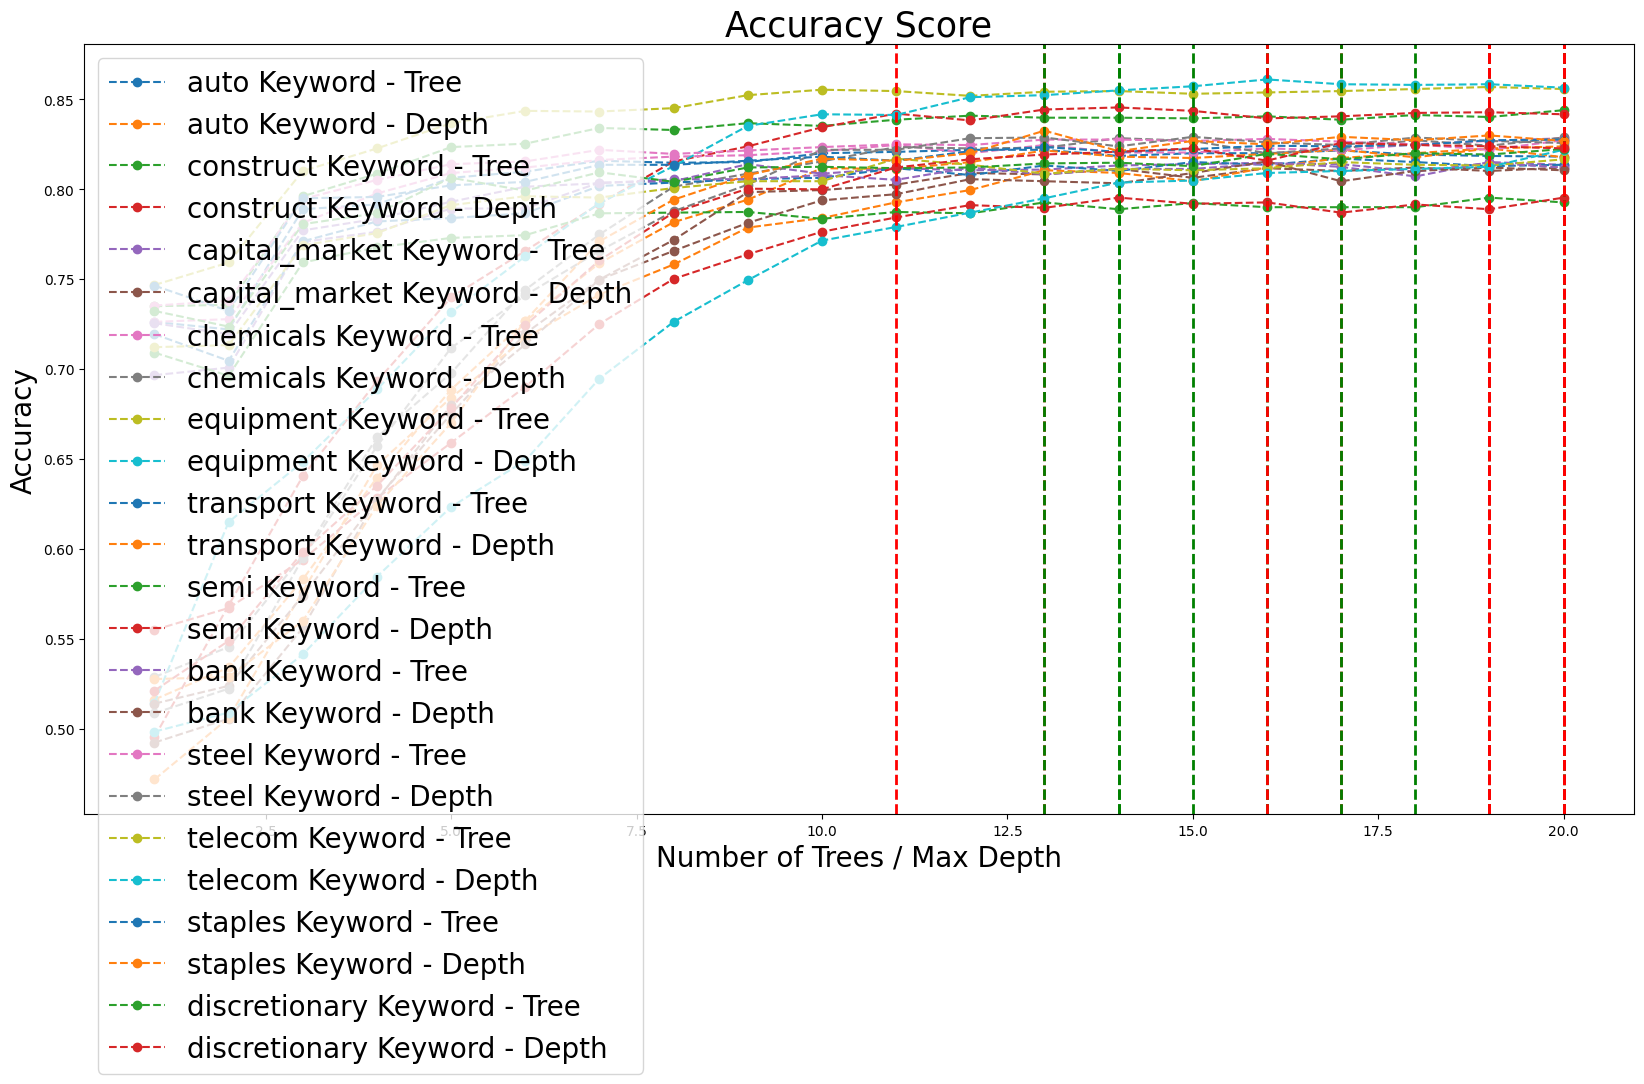

In [11]:

estimator_list = list(range(1, 21))  # 1부터 20까지의 값을 가지는 리스트
depth_list = list(range(1, 21))  # 1부터 20까지의 값을 가지는 리스트

cv_scores_per_keyword = {}  # 각 키워드에 대한 교차 검증 점수를 저장할 딕셔너리
best_estimators_per_keyword = {}  # 각 키워드에 대한 최적의 트리 수를 저장할 딕셔너리
best_depths_per_keyword = {}  # 각 키워드에 대한 최적의 깊이를 저장할 딕셔너리

# 각 키워드에 대한 분류기 및 Voting Classifier 생성
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']
    
    cv_scores = []  # 교차 검증 점수를 저장할 리스트
    cv_scores_depth = []  # 교차 검증 점수를 저장할 리스트
    
    for i in tqdm(range(20)):
        rfc = RandomForestClassifier(n_estimators=i+1,
                                     max_leaf_nodes=300,
                                     n_jobs=-1,
                                     random_state=0)
        score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy').mean()
        cv_scores.append(score)

    best_estimator = estimator_list[np.argmax(cv_scores)]
    best_estimators_per_keyword[keyword] = best_estimator
    
    for i in tqdm(range(20)):
        rfc = RandomForestClassifier(n_estimators=best_estimator,
                                     max_depth=i+1,
                                     max_leaf_nodes=300,
                                     n_jobs=-1,
                                     random_state=0)
        score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy').mean()
        cv_scores_depth.append(score)

    best_depth = depth_list[np.argmax(cv_scores_depth)]
    best_depths_per_keyword[keyword] = best_depth
    
    # 교차 검증 점수를 딕셔너리에 저장
    cv_scores_per_keyword[keyword] = {'tree_scores': cv_scores, 'depth_scores': cv_scores_depth}

# 각 키워드에 대한 최적의 트리 수와 깊이 출력
for keyword in data_splits.keys():
    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]
    print(f"{keyword} 키워드에 대한 최적의 트리 수는 {best_estimator}, 최적의 깊이는 {best_depth} 입니다.")

# 각 키워드에 대한 교차 검증 점수 시각화
plt.figure(figsize=(20, 10))
for keyword, scores in cv_scores_per_keyword.items():
    plt.plot(estimator_list, scores['tree_scores'], marker='o', linestyle='dashed', label=f"{keyword} Keyword - Tree")
    plt.plot(depth_list, scores['depth_scores'], marker='o', linestyle='dashed', label=f"{keyword} Keyword - Depth")
plt.legend(fontsize=20)
plt.xlabel("Number of Trees / Max Depth", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score", fontsize=25)
for keyword in data_splits.keys():
    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]
    plt.axvline(best_estimator, color='r', linestyle='--', linewidth=2)
    plt.axvline(best_depth, color='g', linestyle='--', linewidth=2)
plt.show()


In [12]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # 튜닝할 하이퍼파라미터 조합 지정
# param_grid = {
#     'n_estimators':[best_e[0]-20,best_e[0]-10,best_e[0],best_e[0]+10,best_e[0]+20],  # 결정 트리 개수
#     'max_depth':[ best_depth[0]-20,best_depth[0]-10,best_depth[0],best_depth[0]+10,best_depth[0]+20],  # 최대 깊이
#     'max_leaf_nodes': [None],  # 리프 노드의 최대 개수
# }

# # 그리드 서치 모델 생성
# rfc = RandomForestClassifier(random_state=0)
# grid_search = GridSearchCV(rfc, param_grid ,cv=10,scoring='accuracy')

# # 그리드 서치 수행
# grid_search.fit(X_train, y_train)

# # 최적의 하이퍼파라미터 조합 출력
# print("Best Parameters:", grid_search.best_params_)

# # 최적의 모델 추출
# best_rfc = grid_search.best_estimator_

# # 테스트 데이터에 대한 예측
# y_pred = best_rfc.predict(X_test)

# # 정확도 계산
# acc = accuracy_score(y_true=y_test, y_pred=y_pred)
# print("튜닝된 모델에 대한 성능")  
# print(f"정확도: {acc:.4f}")
# #정확도: 0.8147


In [13]:
# # 최적의 하이퍼 파라미터 셋
# grid_search.best_params_

### 조금더 상승했다!

In [14]:
# best_rfc = RandomForestClassifier(n_estimators= best_e[0],max_depth=best_depth[0],n_jobs=-1,random_state=0)
# # param_grid = {
# #     'max_depth': [10,14,18,22],
# #     'max_leaf_nodes': [100,200,300,400,500],
# #     'criterion':['entropy'],
# #     'max_features':['sqrt']
# # }
# # CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=-1)
# # CV_rfc.fit(X_train, y_train)

In [15]:
# # 최적의 하이퍼 파라미터 셋
# CV_rfc.best_params_

In [16]:
# result_table = pd.DataFrame(CV_rfc.cv_results_)
# result_table = result_table.sort_values(by='mean_test_score', ascending=False)
# print(result_table[['params', 'mean_test_score']])

In [17]:
# best_rfc = CV_rfc.best_estimator_
# best_rfc.fit(X_train, y_train)

### 조금더 상승했다!

auto 키워드에 대한 최적의 트리 개수: 13
auto 키워드에 대한 최적의 깊이 개수: 20


auto 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8151
auto 키워드에 대한 Test set에 대한 성능
정확도: 0.7936

auto 키워드에 대한 Test set에 대한 민감도와 정밀도
민감도: 0.7590, 정밀도: 0.7524



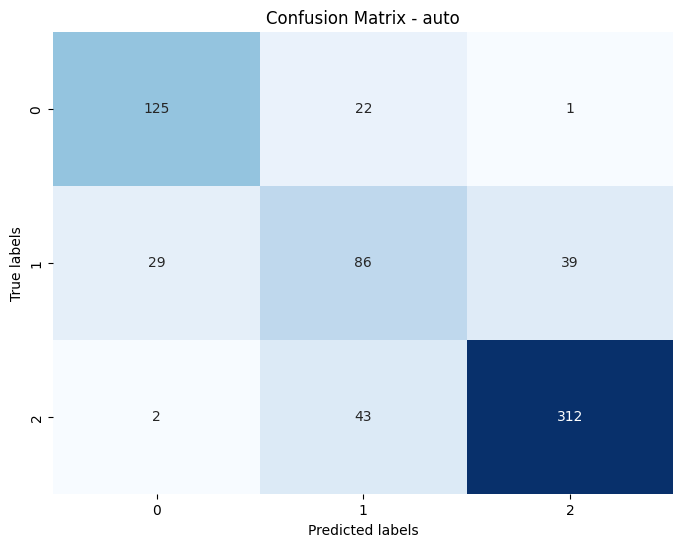

construct 키워드에 대한 최적의 트리 개수: 20
construct 키워드에 대한 최적의 깊이 개수: 14
construct 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8208
construct 키워드에 대한 Test set에 대한 성능
정확도: 0.8194

construct 키워드에 대한 Test set에 대한 민감도와 정밀도
민감도: 0.7851, 정밀도: 0.7853



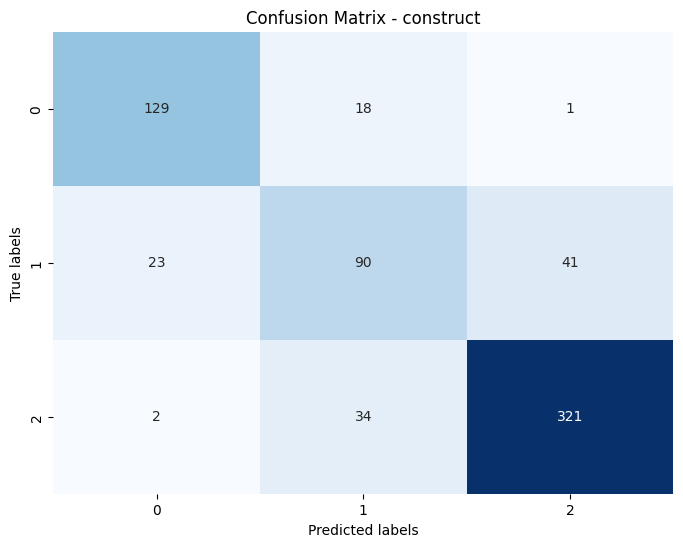

capital_market 키워드에 대한 최적의 트리 개수: 19
capital_market 키워드에 대한 최적의 깊이 개수: 18
capital_market 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8204
capital_market 키워드에 대한 Test set에 대한 성능
정확도: 0.7982

capital_market 키워드에 대한 Test set에 대한 민감도와 정밀도
민감도: 0.7644, 정밀도: 0.7585



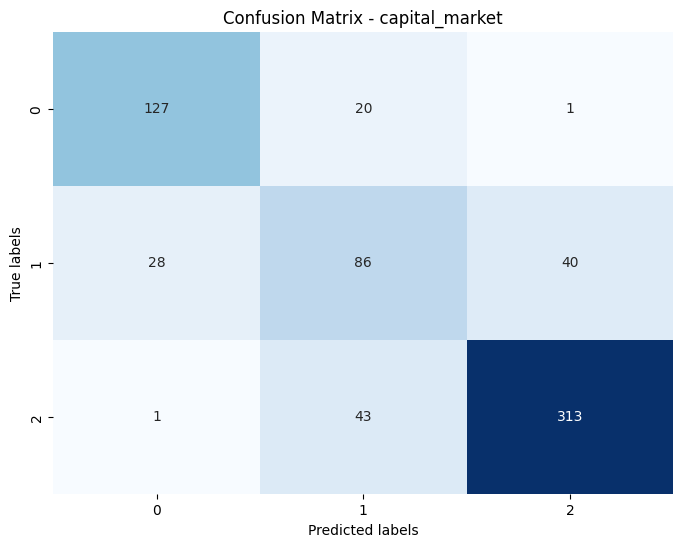

chemicals 키워드에 대한 최적의 트리 개수: 20
chemicals 키워드에 대한 최적의 깊이 개수: 20
chemicals 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8227
chemicals 키워드에 대한 Test set에 대한 성능
정확도: 0.8042

chemicals 키워드에 대한 Test set에 대한 민감도와 정밀도
민감도: 0.7719, 정밀도: 0.7647



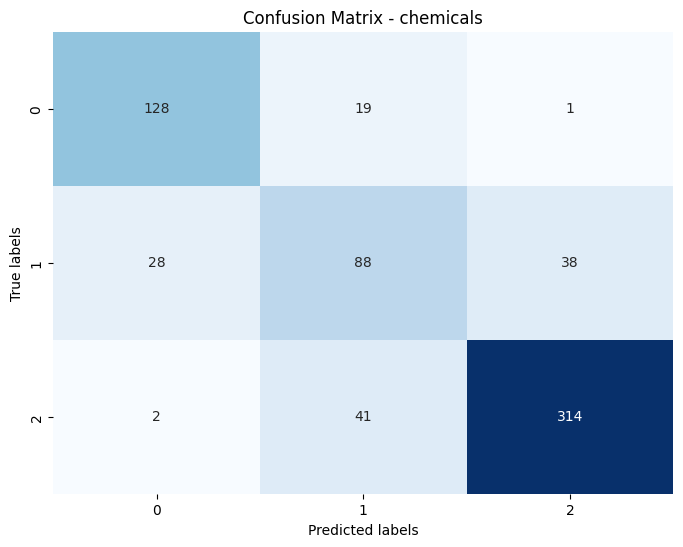

equipment 키워드에 대한 최적의 트리 개수: 19
equipment 키워드에 대한 최적의 깊이 개수: 16
equipment 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8189
equipment 키워드에 대한 Test set에 대한 성능
정확도: 0.7936

equipment 키워드에 대한 Test set에 대한 민감도와 정밀도
민감도: 0.7577, 정밀도: 0.7530



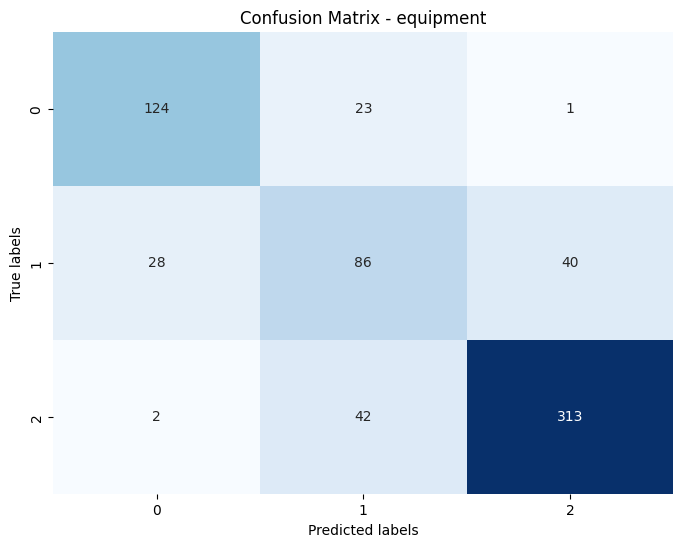

transport 키워드에 대한 최적의 트리 개수: 17
transport 키워드에 대한 최적의 깊이 개수: 19
transport 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8177
transport 키워드에 대한 Test set에 대한 성능
정확도: 0.8058

transport 키워드에 대한 Test set에 대한 민감도와 정밀도
민감도: 0.7753, 정밀도: 0.7681



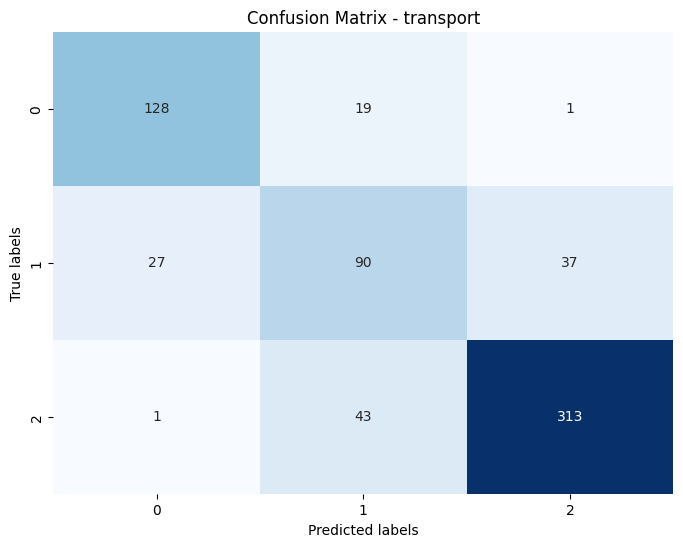

semi 키워드에 대한 최적의 트리 개수: 19
semi 키워드에 대한 최적의 깊이 개수: 14
semi 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8200
semi 키워드에 대한 Test set에 대한 성능
정확도: 0.8118

semi 키워드에 대한 Test set에 대한 민감도와 정밀도
민감도: 0.7752, 정밀도: 0.7762



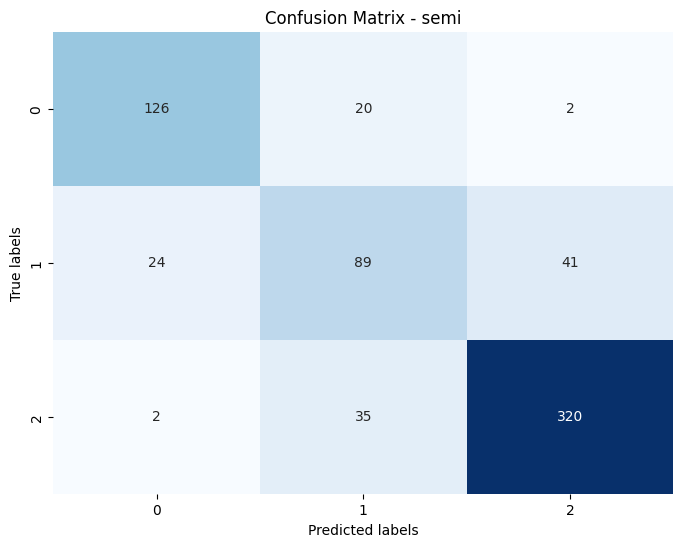

bank 키워드에 대한 최적의 트리 개수: 19
bank 키워드에 대한 최적의 깊이 개수: 16
bank 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8189
bank 키워드에 대한 Test set에 대한 성능
정확도: 0.7936

bank 키워드에 대한 Test set에 대한 민감도와 정밀도
민감도: 0.7577, 정밀도: 0.7530



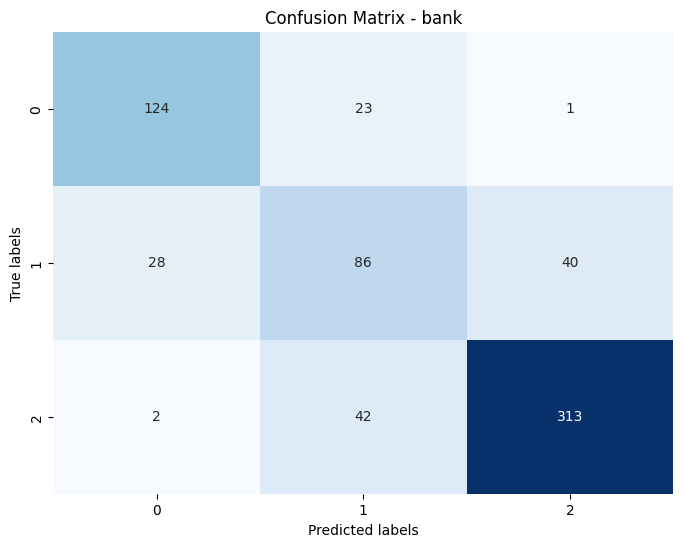

steel 키워드에 대한 최적의 트리 개수: 16
steel 키워드에 대한 최적의 깊이 개수: 15
steel 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8189
steel 키워드에 대한 Test set에 대한 성능
정확도: 0.8042

steel 키워드에 대한 Test set에 대한 민감도와 정밀도
민감도: 0.7693, 정밀도: 0.7656



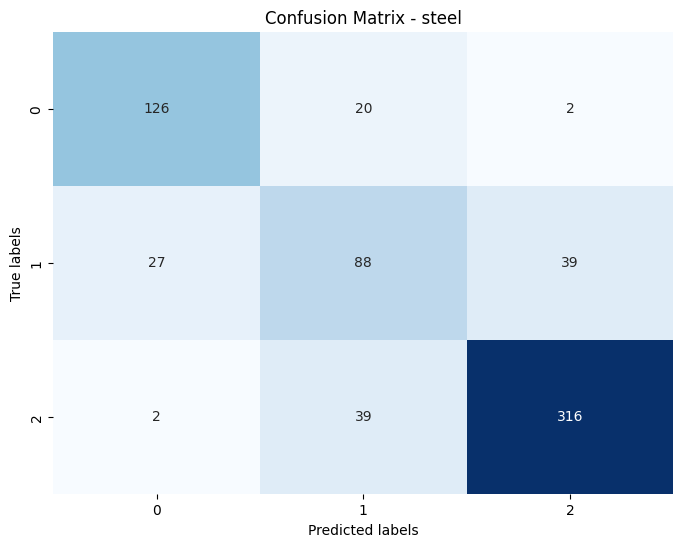

telecom 키워드에 대한 최적의 트리 개수: 11
telecom 키워드에 대한 최적의 깊이 개수: 20
telecom 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8120
telecom 키워드에 대한 Test set에 대한 성능
정확도: 0.7936

telecom 키워드에 대한 Test set에 대한 민감도와 정밀도
민감도: 0.7564, 정밀도: 0.7546



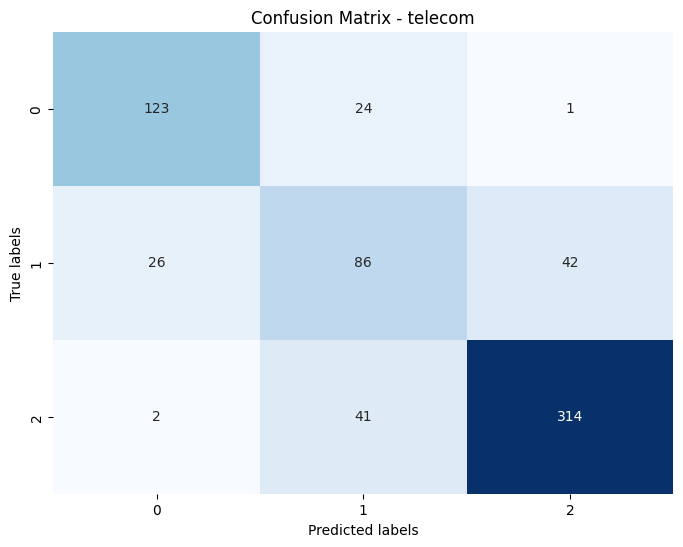

staples 키워드에 대한 최적의 트리 개수: 20
staples 키워드에 대한 최적의 깊이 개수: 13
staples 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8192
staples 키워드에 대한 Test set에 대한 성능
정확도: 0.8058

staples 키워드에 대한 Test set에 대한 민감도와 정밀도
민감도: 0.7639, 정밀도: 0.7658



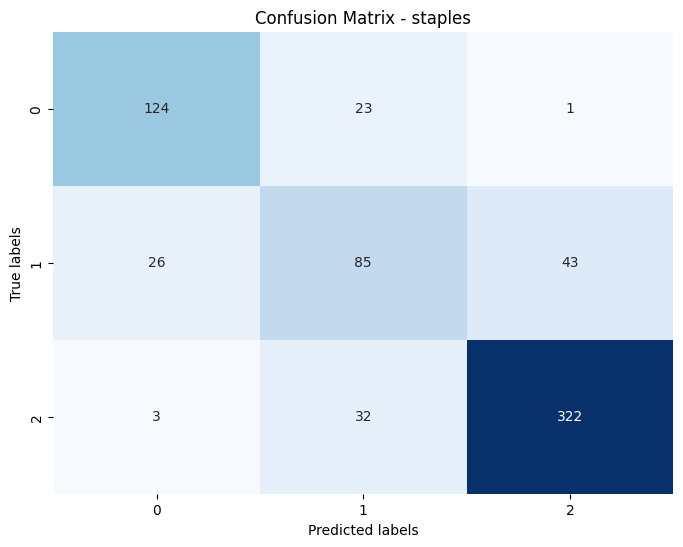

discretionary 키워드에 대한 최적의 트리 개수: 20
discretionary 키워드에 대한 최적의 깊이 개수: 17
discretionary 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8257
discretionary 키워드에 대한 Test set에 대한 성능
정확도: 0.8042

discretionary 키워드에 대한 Test set에 대한 민감도와 정밀도
민감도: 0.7680, 정밀도: 0.7638



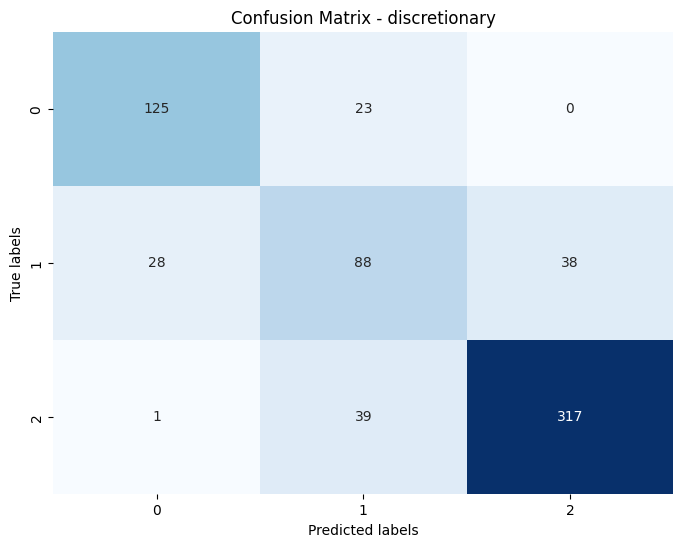

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 각 키워드별 최적의 트리 개수와 최적의 깊이 출력
for keyword in data_splits.keys():
    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]
    print(f"{keyword} 키워드에 대한 최적의 트리 개수: {best_estimator}")
    print(f"{keyword} 키워드에 대한 최적의 깊이 개수: {best_depth}")
    
    # 최적의 트리 개수와 깊이를 사용하여 RandomForestClassifier 초기화
    rfc = RandomForestClassifier(n_estimators=best_estimator, 
                                 max_depth=best_depth, 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)
    
    # 교차 검증을 통한 정확도 측정
    cv_scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy')
    
    # 평균 정확도 출력
    print(f"{keyword} 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)")
    print(f"평균 정확도: {cv_scores.mean():.4f}")
    
    # Train set에 대한 최적의 모델 학습
    rfc.fit(X_train, y_train)
    
    # Test set에 대한 예측값 생성
    y_pred = rfc.predict(X_test)
    
    # Test set에 대한 정확도 계산 및 출력
    acc_test = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(f"{keyword} 키워드에 대한 Test set에 대한 성능")
    print(f"정확도: {acc_test:.4f}\n")
    
    # Test set에 대한 민감도와 정밀도 계산
    recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')

    # 민감도와 정밀도 출력
    print(f"{keyword} 키워드에 대한 Test set에 대한 민감도와 정밀도")
    print(f"민감도: {recall:.4f}, 정밀도: {precision:.4f}\n")
    
    # 혼동 행렬 생성
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='d', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {keyword}')
    plt.show()


### 너무 많다.. 10개로


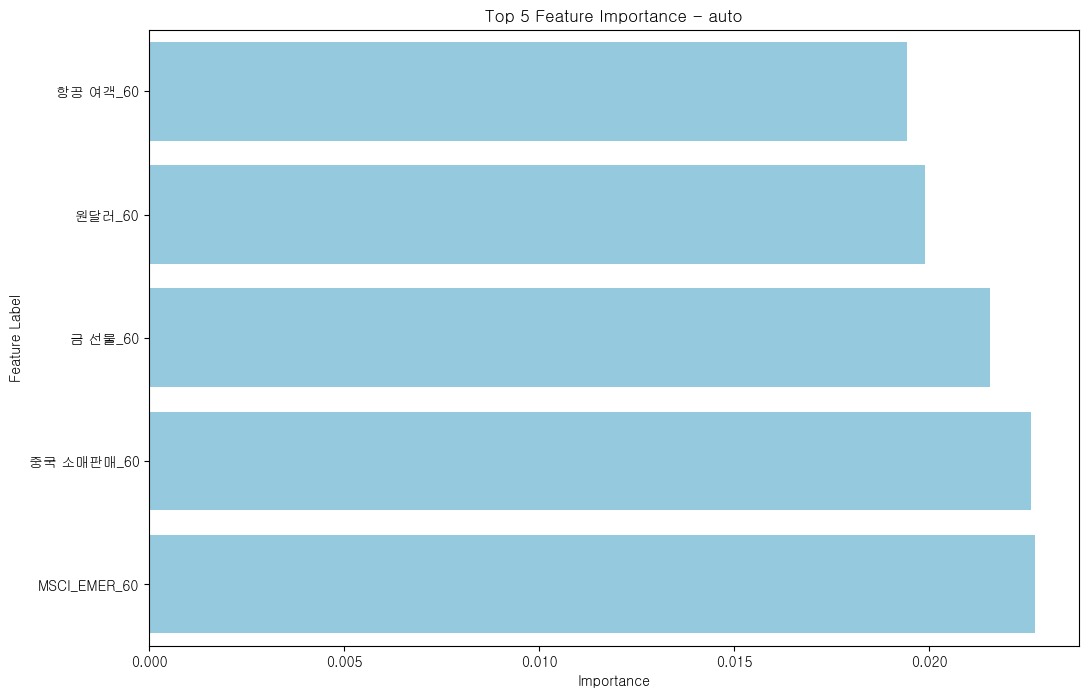

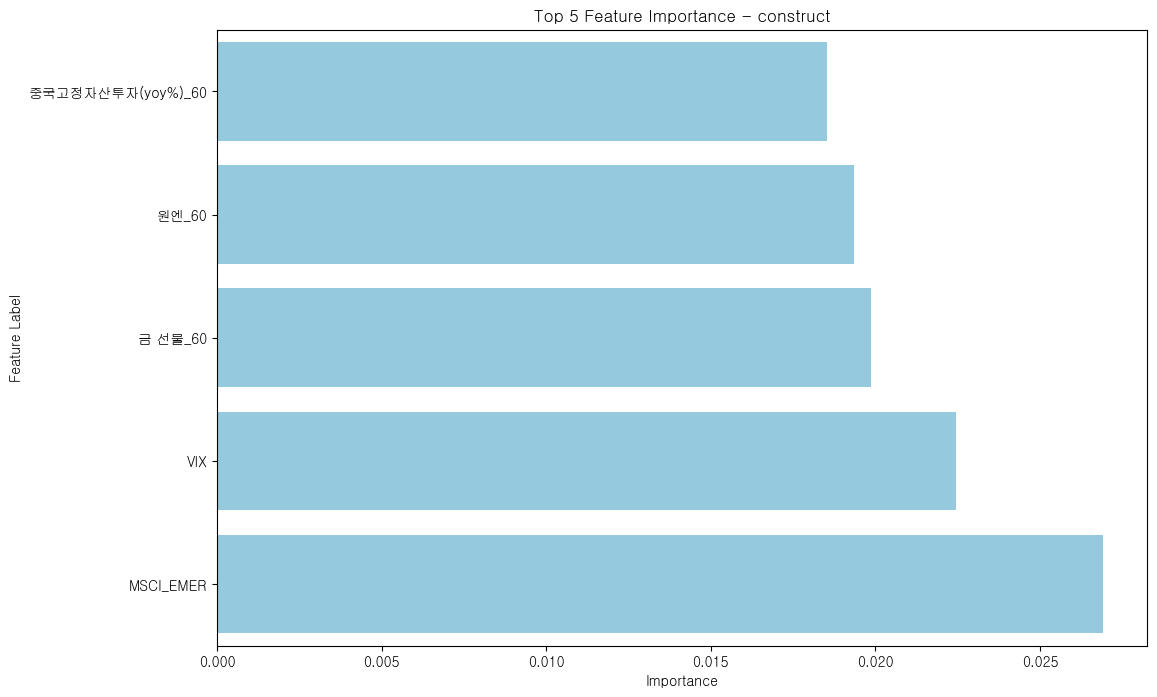

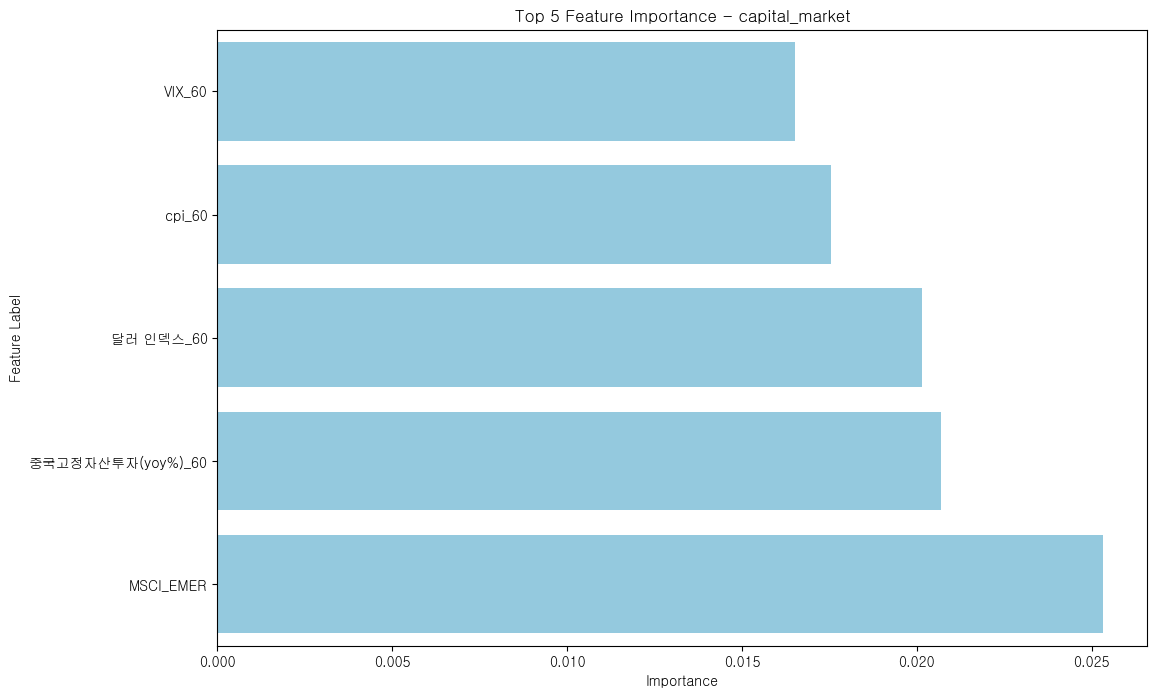

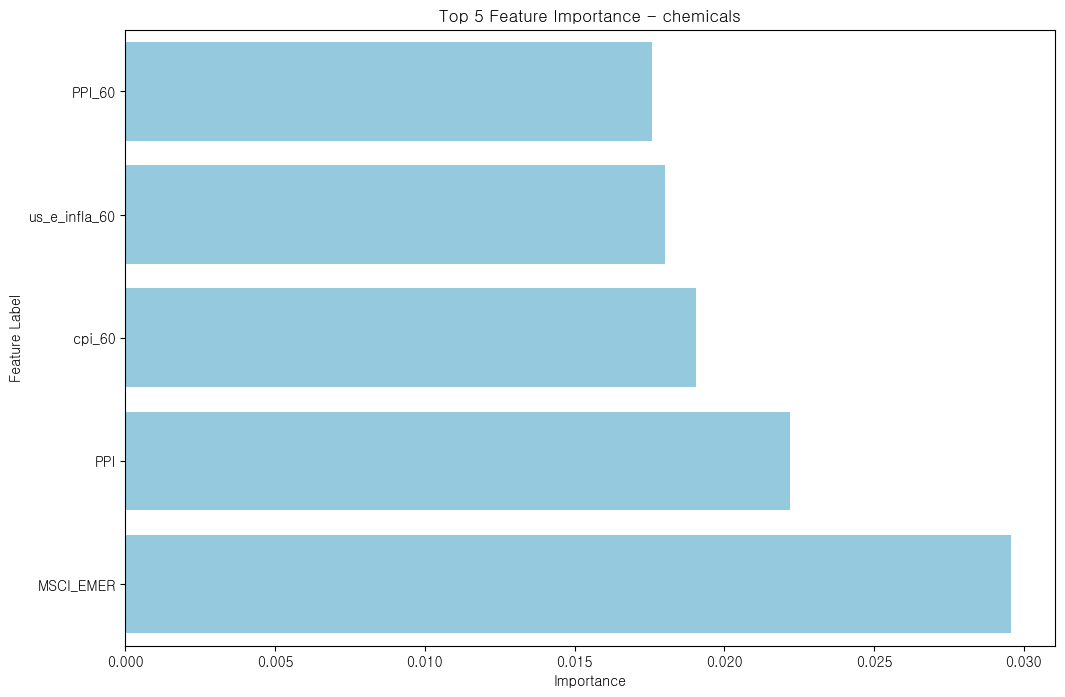

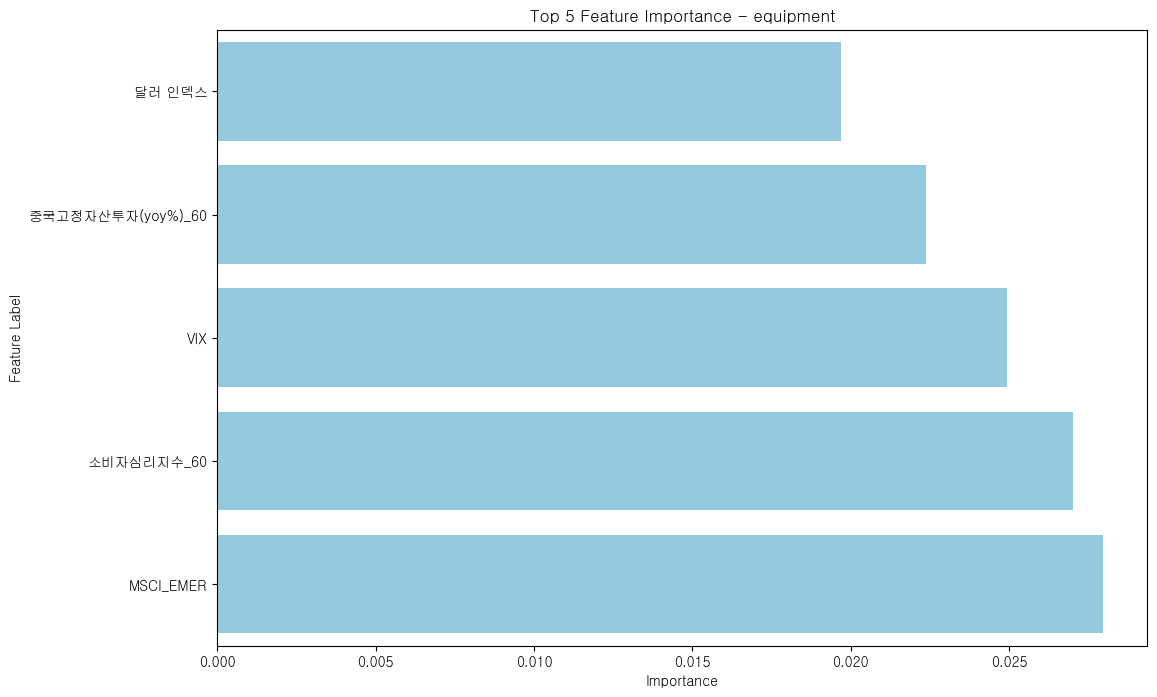

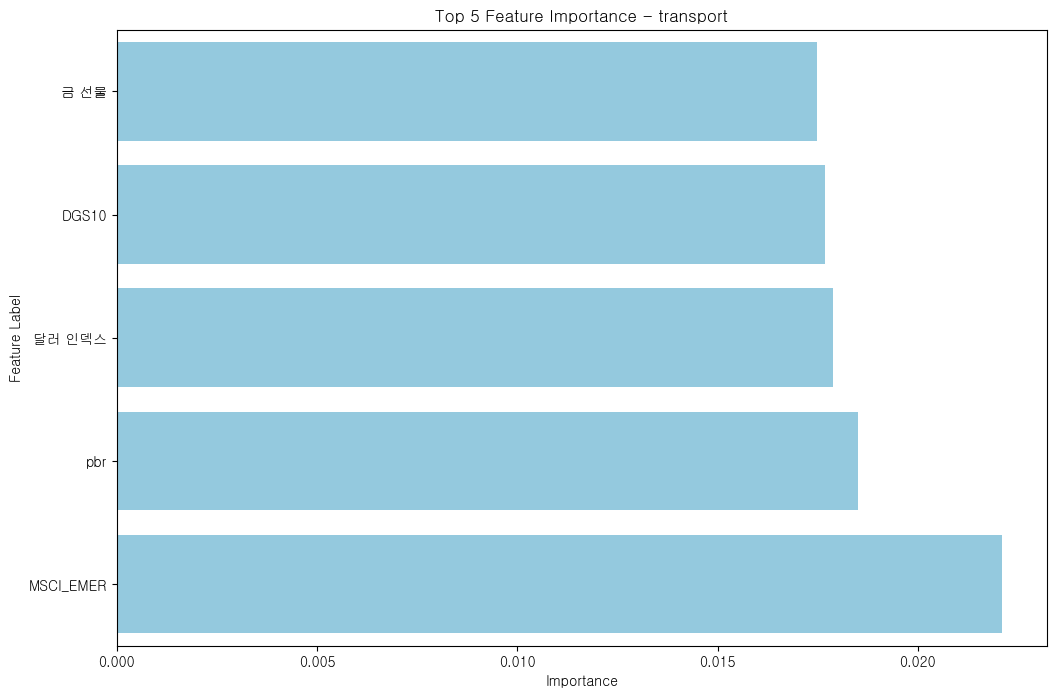

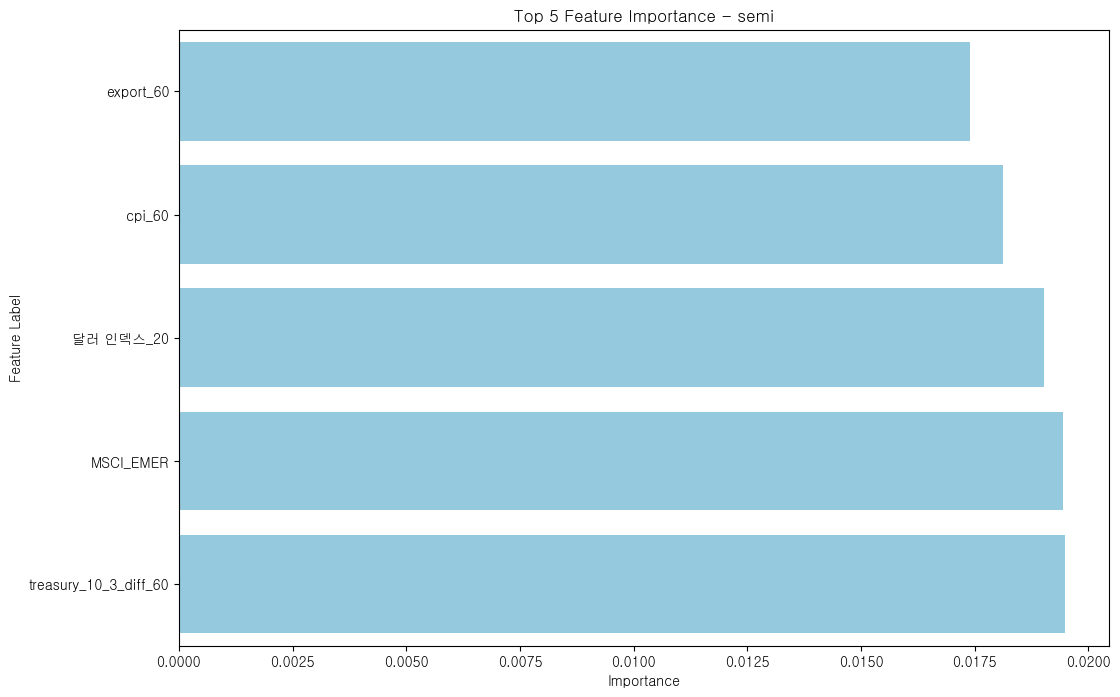

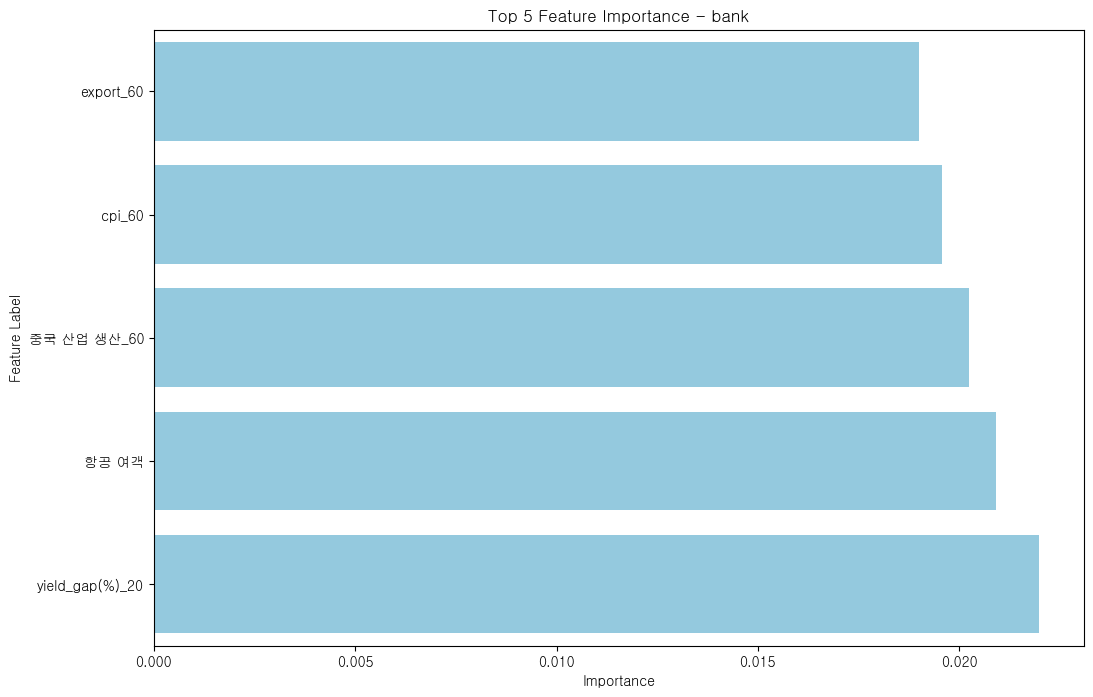

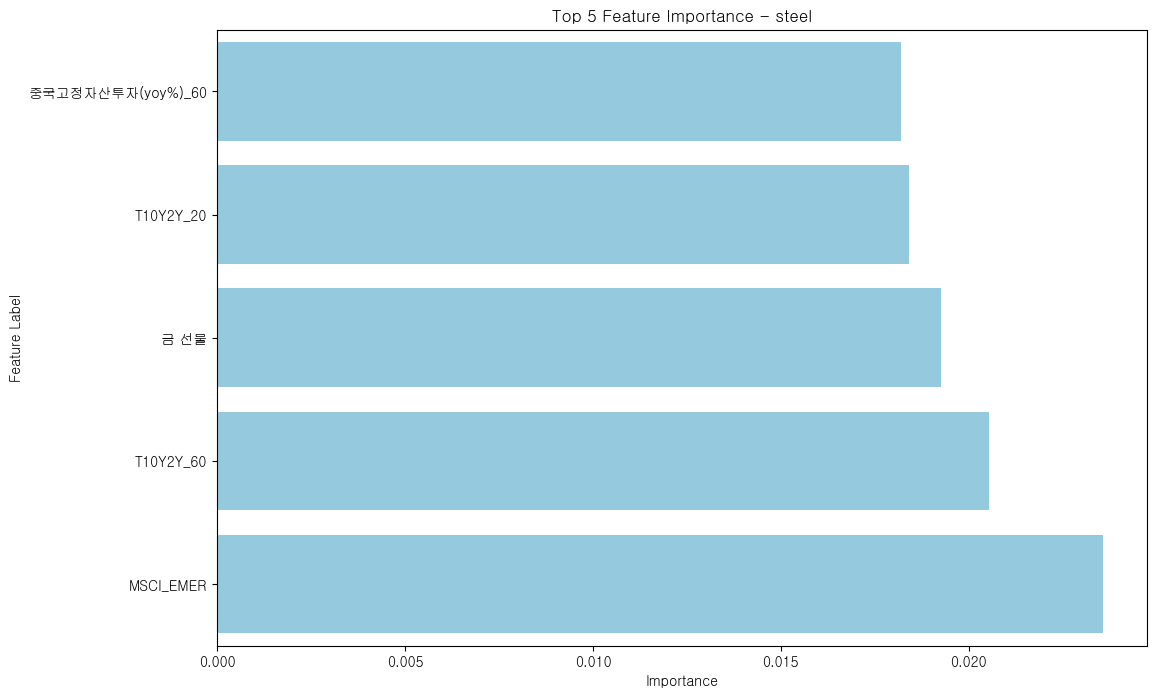

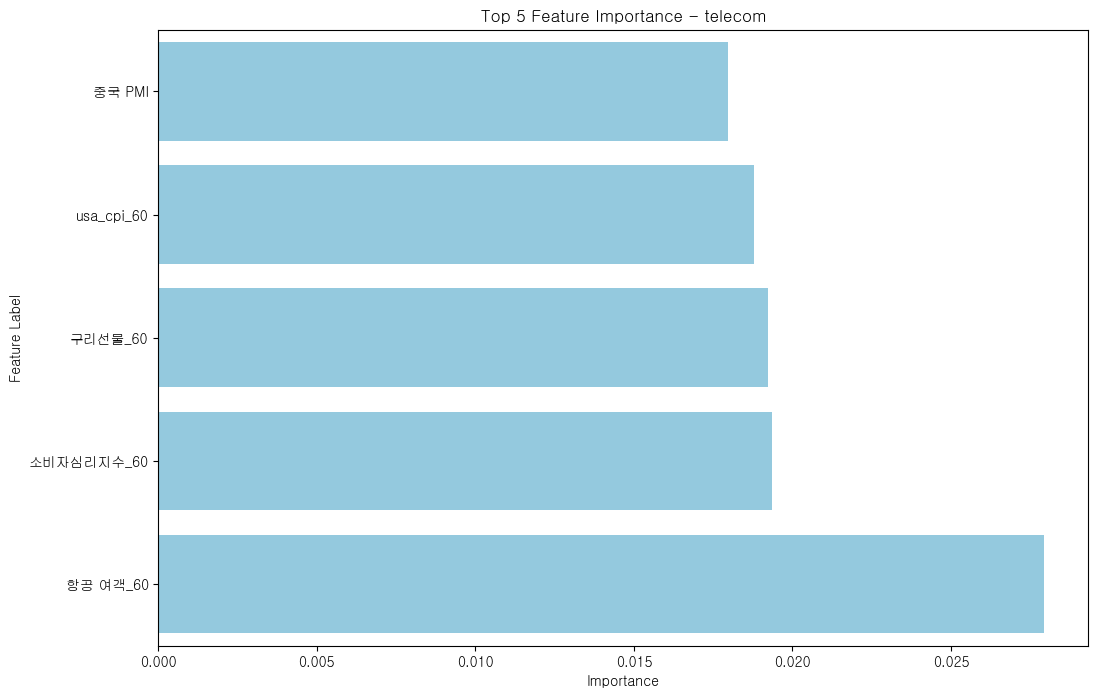

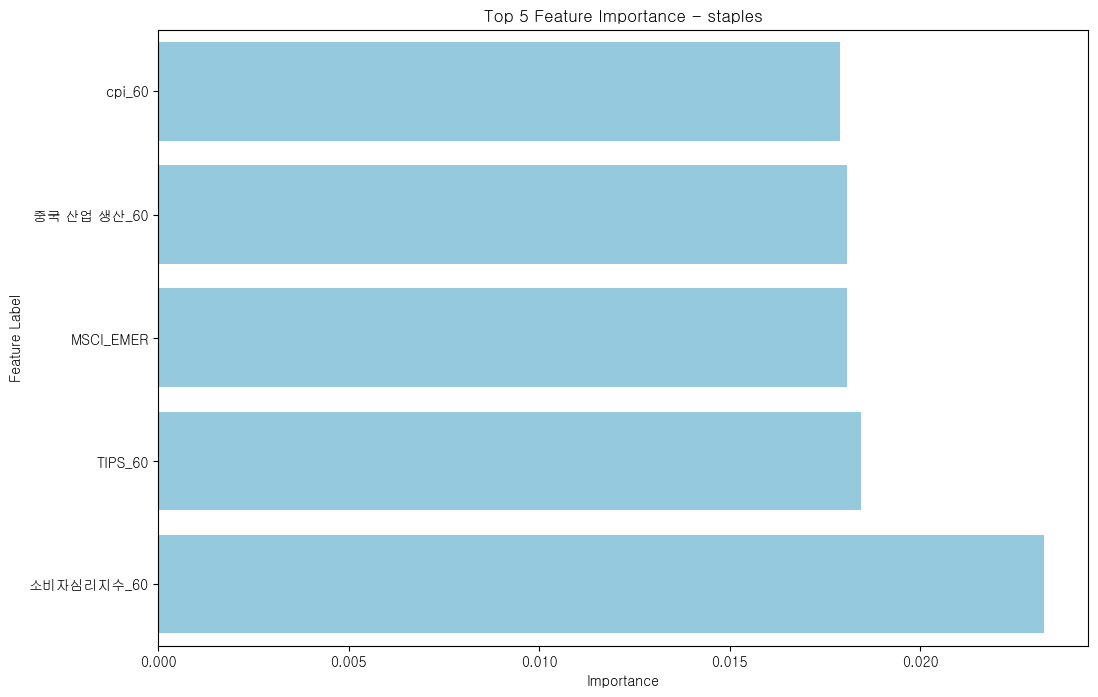

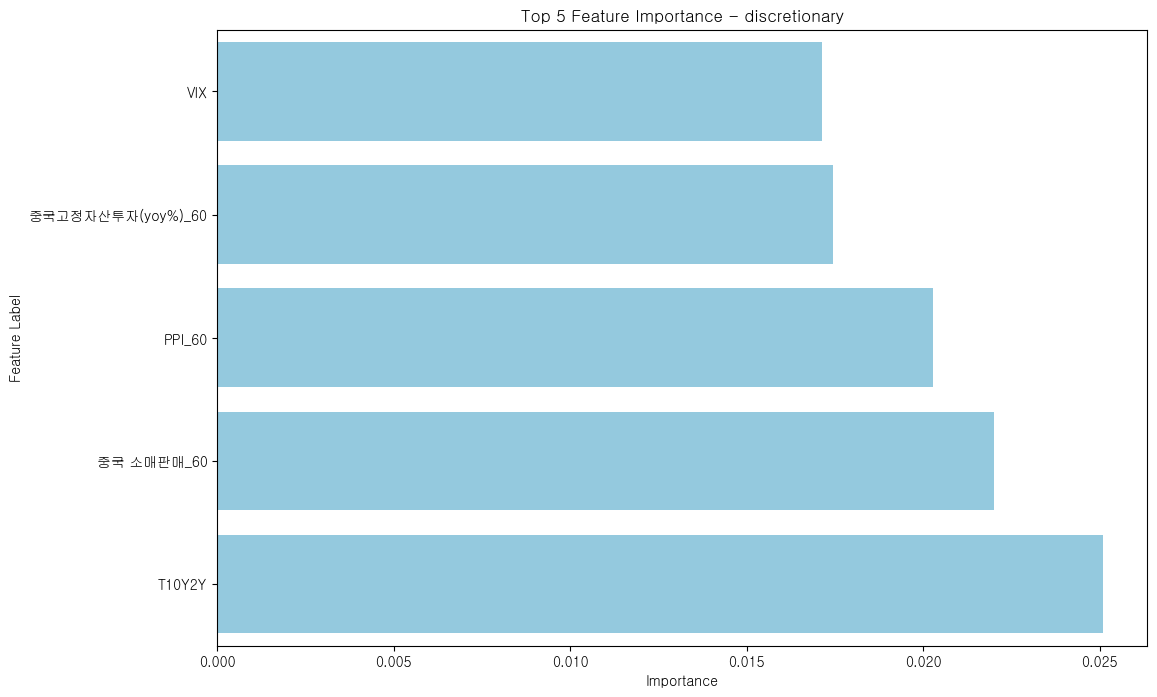

In [19]:
# 필요한 라이브러리 import
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
from matplotlib import font_manager, rc
path = f'C:/Windows/Fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

# 각 키워드별 상위 5개 특성의 label과 중요도 저장
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']

    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]

    # RandomForestClassifier 초기화 및 학습
    rfc = RandomForestClassifier(n_estimators=best_estimator, 
                                 max_depth=best_depth, 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)
    rfc.fit(X_train, y_train)

    # Feature Importance 계산
    feats = {}
    for feature, importance in zip(range(X_train.shape[1]), rfc.feature_importances_):
        feats[feature] = importance

    # 중요도 순으로 정렬하여 상위 5개 선택
    sorted_feats = sorted(feats.items(), key=lambda x: x[1], reverse=True)
    top_5_importances = sorted_feats[:5]

    # 상위 5개 특성의 label과 중요도 추출
    feature_labels = [X_keyword.columns[feature_index] for feature_index, _ in top_5_importances]
    importances = [importance for _, importance in top_5_importances]

    # 그래프 출력
    plt.figure(figsize=(12, 8))
    sns.barplot(x=importances, y=feature_labels, color='skyblue')
    plt.title(f'Top 5 Feature Importance - {keyword}')
    plt.xlabel('Importance')
    plt.ylabel('Feature Label')
    plt.gca().invert_yaxis()  # y축 라벨 역순으로 표시
    plt.show()


### 생각보다 자동차지수와 중국 지표 금 구리 이런게 영향을 많이 미치는구마잉!

Model for auto keyword saved as plk_folder/auto_model.pkl
Model for construct keyword saved as plk_folder/construct_model.pkl
Model for capital_market keyword saved as plk_folder/capital_market_model.pkl
Model for chemicals keyword saved as plk_folder/chemicals_model.pkl
Model for equipment keyword saved as plk_folder/equipment_model.pkl
Model for transport keyword saved as plk_folder/transport_model.pkl
Model for semi keyword saved as plk_folder/semi_model.pkl
Model for bank keyword saved as plk_folder/bank_model.pkl
Model for steel keyword saved as plk_folder/steel_model.pkl
Model for telecom keyword saved as plk_folder/telecom_model.pkl
Model for staples keyword saved as plk_folder/staples_model.pkl
Model for discretionary keyword saved as plk_folder/discretionary_model.pkl

< AI model: save >
Model for auto keyword loaded from plk_folder/auto_model.pkl
Model for construct keyword loaded from plk_folder/construct_model.pkl
Model for capital_market keyword loaded from plk_folder/capi

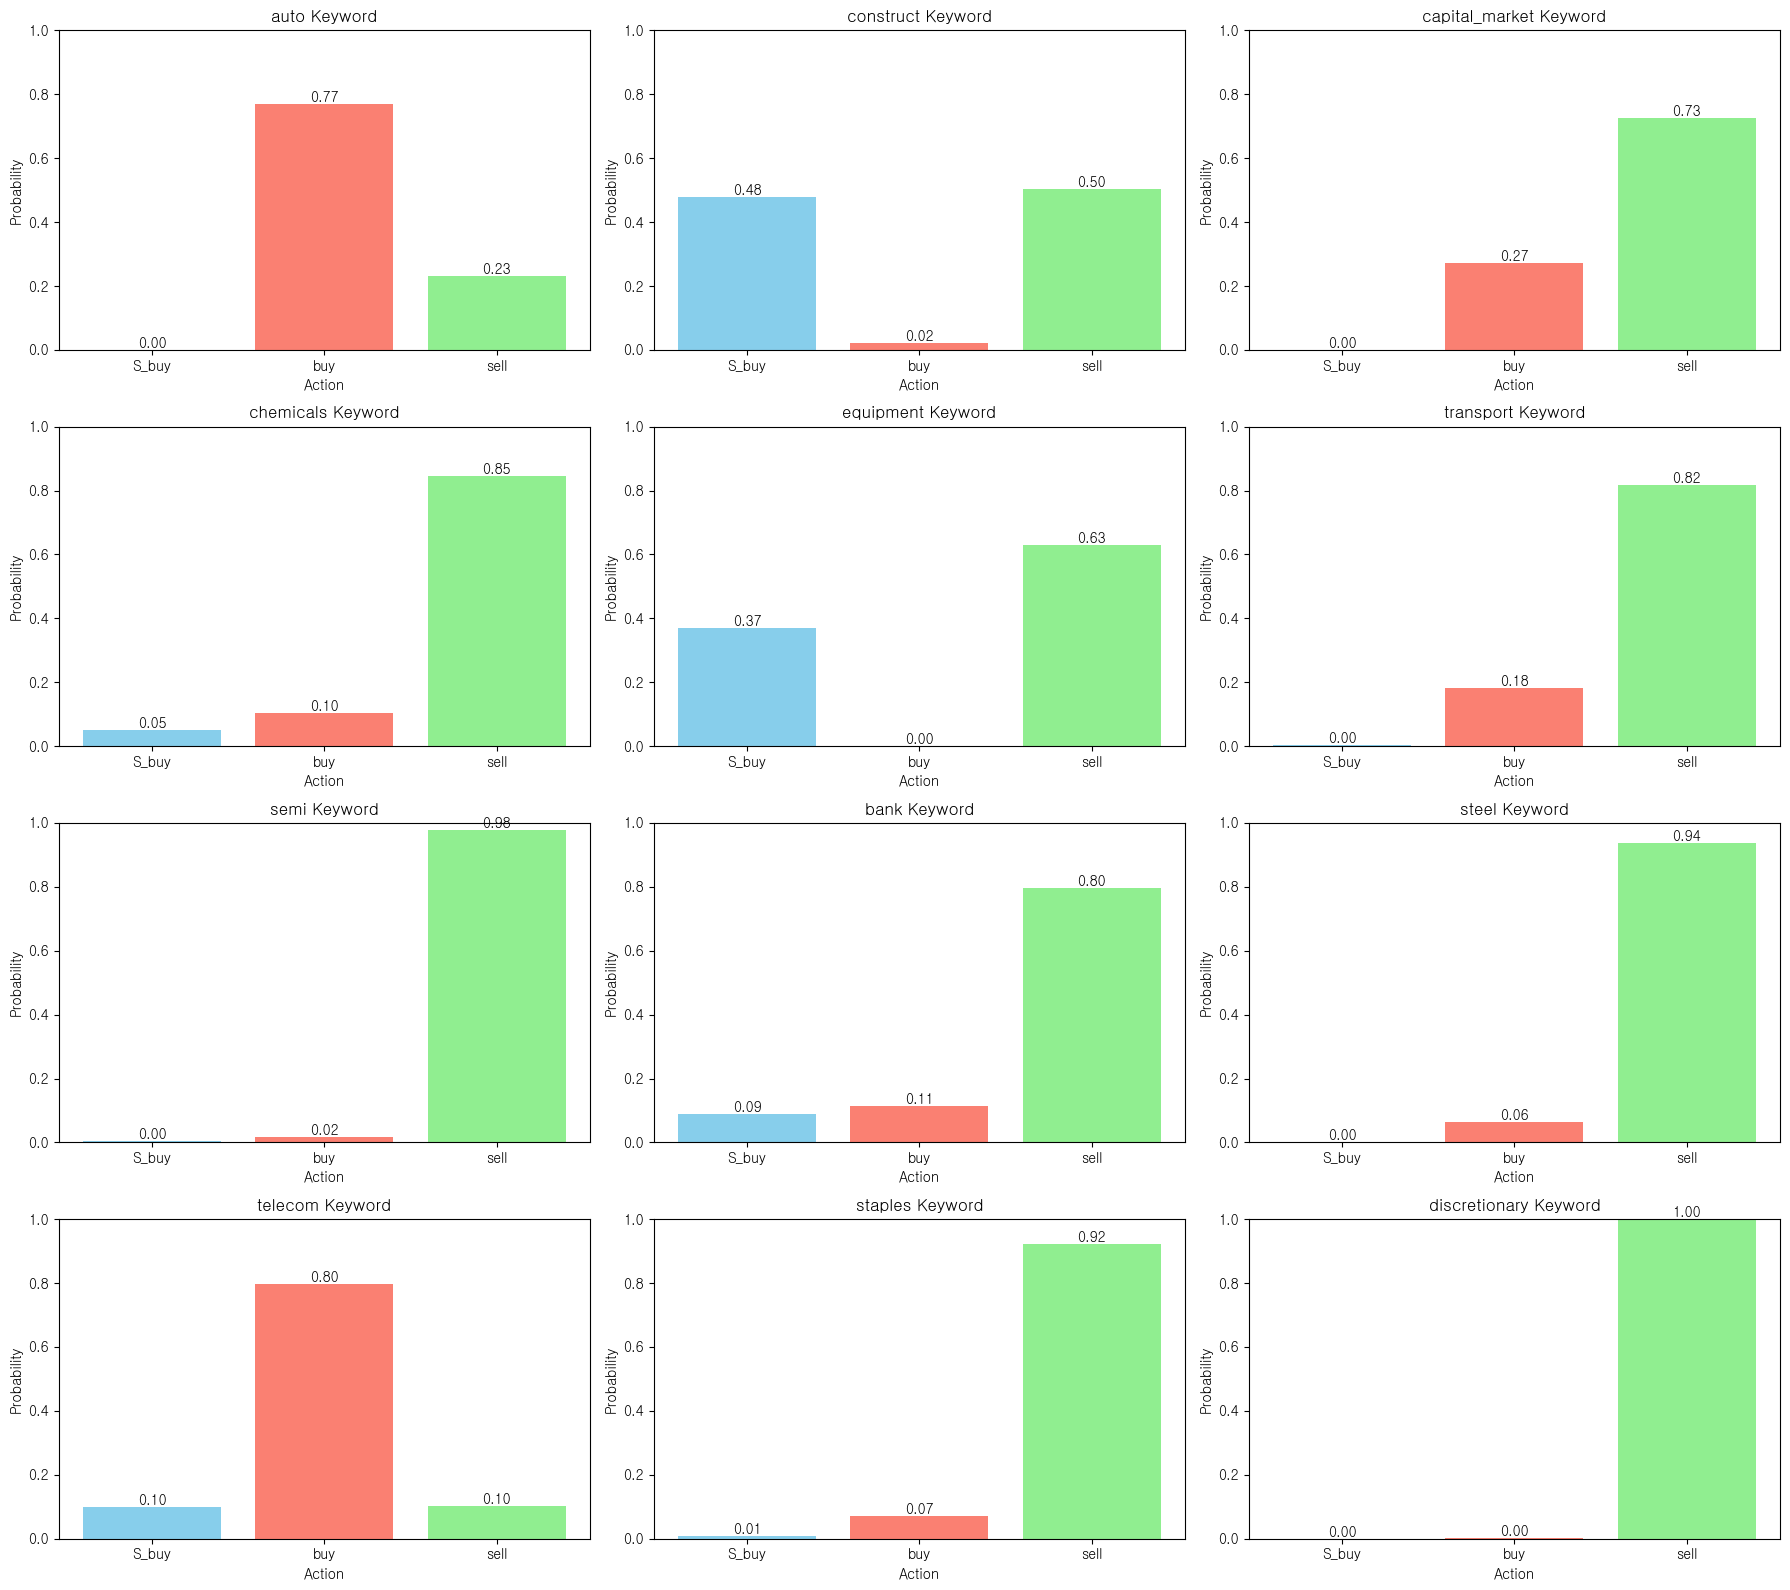

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# 디렉토리가 없다면 생성
if not os.path.exists('plk_folder'):
    os.makedirs('plk_folder')

# 각 키워드별로 최종 모델 학습 및 모델 저장
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']

    # RandomForestClassifier 초기화
    rfc = RandomForestClassifier(n_estimators=best_estimators_per_keyword[keyword], 
                                 max_depth=best_depths_per_keyword[keyword], 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)

    # 최종 모델 학습
    rfc.fit(X_train, y_train)

    # 모델 저장
    filename = f"plk_folder/{keyword}_model.pkl"
    dump(rfc, filename)
    print(f"Model for {keyword} keyword saved as {filename}")

print("\n< AI model: save >")

# 모델 로드
loaded_models = {}

# 각 키워드별로 모델 로드
for keyword in keywords:
    filename = f"plk_folder/{keyword}_model.pkl"
    if os.path.exists(filename):
        loaded_models[keyword] = load(filename)
        print(f"Model for {keyword} keyword loaded from {filename}")
    else:
        print(f"Model file for {keyword} keyword does not exist: {filename}")

print("\n< AI model: load >")

# 각 키워드별로 S_buy, buy, sell의 확률 예측
probabilities = {}
for keyword, model in loaded_models.items():
    X_test = data_splits[keyword]['X_test'][-1].reshape(1, -1)

    # 각 클래스의 확률 예측
    prob_current = model.predict_proba(X_test)
    y_names = model.classes_

    # 결과 저장
    probabilities[keyword] = {'S_buy': prob_current[0][0], 'buy': prob_current[0][1], 'sell': prob_current[0][2]}

# 그래프로 출력
num_keywords = len(probabilities)
num_rows = (num_keywords + 2) // 3
num_cols = min(num_keywords, 3)
plt.figure(figsize=(6 * num_cols, 4 * num_rows))

for i, (keyword, probs) in enumerate(probabilities.items(), start=1):
    plt.subplot(num_rows, num_cols, i)
    plt.bar(probs.keys(), probs.values(), color=['skyblue', 'salmon', 'lightgreen'])
    plt.title(f'{keyword} Keyword')
    plt.xlabel('Action')
    plt.ylabel('Probability')
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    for j, prob in enumerate(probs.values()):
        plt.text(j, prob, f'{prob:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


Model for auto keyword saved as plk_folder/auto_model.pkl
Model for construct keyword saved as plk_folder/construct_model.pkl
Model for capital_market keyword saved as plk_folder/capital_market_model.pkl
Model for chemicals keyword saved as plk_folder/chemicals_model.pkl
Model for equipment keyword saved as plk_folder/equipment_model.pkl
Model for transport keyword saved as plk_folder/transport_model.pkl
Model for semi keyword saved as plk_folder/semi_model.pkl
Model for bank keyword saved as plk_folder/bank_model.pkl
Model for steel keyword saved as plk_folder/steel_model.pkl
Model for telecom keyword saved as plk_folder/telecom_model.pkl
Model for staples keyword saved as plk_folder/staples_model.pkl
Model for discretionary keyword saved as plk_folder/discretionary_model.pkl

< AI model: save >
Model for auto keyword loaded from plk_folder/auto_model.pkl
Model for construct keyword loaded from plk_folder/construct_model.pkl
Model for capital_market keyword loaded from plk_folder/capi

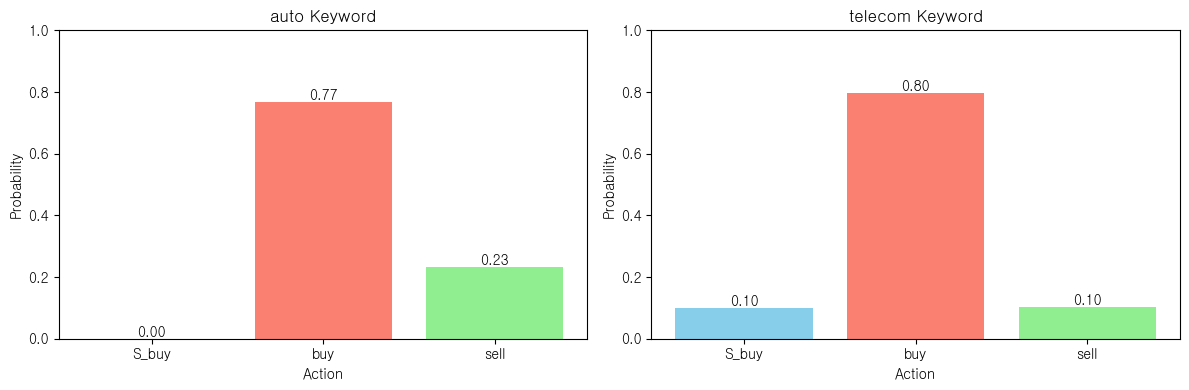

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# 디렉토리가 없다면 생성
if not os.path.exists('plk_folder'):
    os.makedirs('plk_folder')

# 각 키워드별로 최종 모델 학습 및 모델 저장
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']

    # RandomForestClassifier 초기화
    rfc = RandomForestClassifier(n_estimators=best_estimators_per_keyword[keyword], 
                                 max_depth=best_depths_per_keyword[keyword], 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)

    # 최종 모델 학습
    rfc.fit(X_train, y_train)

    # 모델 저장
    filename = f"plk_folder/{keyword}_model.pkl"
    dump(rfc, filename)
    print(f"Model for {keyword} keyword saved as {filename}")

print("\n< AI model: save >")

# 모델 로드
loaded_models = {}

# 각 키워드별로 모델 로드
for keyword in keywords:
    filename = f"plk_folder/{keyword}_model.pkl"
    if os.path.exists(filename):
        loaded_models[keyword] = load(filename)
        print(f"Model for {keyword} keyword loaded from {filename}")
    else:
        print(f"Model file for {keyword} keyword does not exist: {filename}")

print("\n< AI model: load >")

# 각 키워드별로 S_buy, buy, sell의 확률 예측
probabilities = {}
for keyword, model in loaded_models.items():
    X_test = data_splits[keyword]['X_test'][-1].reshape(1, -1)

    # 각 클래스의 확률 예측
    prob_current = model.predict_proba(X_test)
    s_buy_buy_sum = prob_current[0][0] + prob_current[0][1]

    # S_buy와 buy의 합이 0.6을 넘어가는지 확인
    if s_buy_buy_sum > 0.6:
        probabilities[keyword] = {'S_buy': prob_current[0][0], 'buy': prob_current[0][1], 'sell': prob_current[0][2]}

# 그래프로 출력
num_keywords = len(probabilities)
num_rows = (num_keywords + 2) // 3
num_cols = min(num_keywords, 3)
plt.figure(figsize=(6 * num_cols, 4 * num_rows))

for i, (keyword, probs) in enumerate(probabilities.items(), start=1):
    plt.subplot(num_rows, num_cols, i)
    plt.bar(probs.keys(), probs.values(), color=['skyblue', 'salmon', 'lightgreen'])
    plt.title(f'{keyword} Keyword')
    plt.xlabel('Action')
    plt.ylabel('Probability')
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    for j, prob in enumerate(probs.values()):
        plt.text(j, prob, f'{prob:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()
